## 数据
特别是对于视觉，PyTorch创建了一个名为的包 torchvision，它包含用于常见数据集的数据加载器，如Imagenet，CIFAR10，MNIST等，以及用于图像的数据转换器，即 torchvision.datasets和torch.utils.data.DataLoader。

这提供了极大的便利并避免编写样板代码。

在本教程中，我们将使用CIFAR10数据集。它有类：'飞机'，'汽车'，'鸟'，'猫'，'鹿'，'狗'，'青蛙'，'马'，'船'，'卡车'。CIFAR-10中的图像尺寸为3x32x32，即尺寸为32x32像素的3通道彩色图像。
![](https://pytorch.org/tutorials/_images/cifar10.png)

## 图像分类器
我们将按顺序执行以下步骤：

- 使用加载和标准化CIFAR10训练和测试数据集 torchvision
- 定义卷积神经网络
- 定义损失函数
- 在训练数据上训练网络
- 在测试数据上测试网络

## 1.加载和标准化CIFAR10

使用torchvision，加载CIFAR10非常容易

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision数据集的输出是范围[0,1]的PILImage图像。我们将它们转换为归一化范围的张量[-1,1]

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


我们展示一些数据

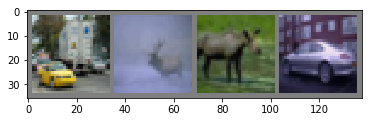

  car  deer  deer   car


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

## 2.定义卷积神经网络
从神经网络部分复制神经网络并修改它以获取3通道图像（而不是定义的1通道图像）。

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3.定义损失函数和优化程序

让我们使用分类交叉熵损失和SGD动量。

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4.训练网络
这是事情开始变得有趣的时候。我们只需循环遍历数据迭代器，并将输入提供给网络并进行优化。

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.183
[1,  4000] loss: 1.901
[1,  6000] loss: 1.682
[1,  8000] loss: 1.573
[1, 10000] loss: 1.509
[1, 12000] loss: 1.474
[2,  2000] loss: 1.406
[2,  4000] loss: 1.376
[2,  6000] loss: 1.328
[2,  8000] loss: 1.323
[2, 10000] loss: 1.297
[2, 12000] loss: 1.294
Finished Training


## 5.在测试数据上测试网络

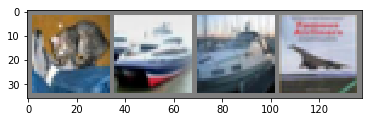

GroundTruth:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

网络预测

In [12]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


结果看起来很好，我们在整个数据集看下准确率

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %
